In [10]:

import requests
import pandas as pd
import matplotlib.pyplot as plt

import json



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
# OpenWeatherMap API configuration
# Note: You'll need to sign up at openweathermap.org to get your API key
API_KEY = "0ee9a2df9829a6bf153af3e505b4d119"  # Replace with your actual API key
CITY = "Paphos"
COUNTRY_CODE = "CY"
LANG = "EN"

URL = "https://api.openweathermap.org/data/2.5/forecast"


In [12]:
def get_weather_data():
    """Fetch weather forecast for city"""

    # Parameters dictionary
    params = {
        'q': f"{CITY},{COUNTRY_CODE}",
        'appid': API_KEY,
        'lang': LANG,
        'units': 'metric'
    }

    try:
        response = requests.get(URL, params=params)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None


def process_weather_data(data):
    """Process the weather data into a pandas DataFrame"""
    if not data:
        return None

    weather_list = []

    for item in data['list']:
        weather_info = {
            'datetime': pd.to_datetime(item['dt'], unit='s'),
            'temperature': item['main']['temp'],
            'temp_min': item['main']['temp_min'],
            'temp_max': item['main']['temp_max'],
            'feels_like': item['main']['feels_like'],
            'humidity': item['main']['humidity'],
            'pressure': item['main']['pressure'],
            'description': item['weather'][0]['description'],
            'wind_speed': item['wind']['speed'],
            'wind_direction': item['wind'].get('deg', 0),
            'clouds': item['clouds']['all']
        }
        weather_list.append(weather_info)

    df = pd.DataFrame(weather_list)
    df['date'] = df['datetime'].dt.date

    return df


In [13]:
# Fetch and process data
print("Fetching weather data for Paphos...")
raw_data = get_weather_data()

if raw_data:
    print("Raw API Response:")
    print("=" * 50)
    print(json.dumps(raw_data, indent=2))
    print("=" * 50)

    weather_df = process_weather_data(raw_data)
    print(f"\nWeather forecast for {CITY}")
    print("=" * 50)
else:
    print("Failed to fetch weather data. Please check your API key and internet connection.")
    print("\nTo use this script:")
    print("1. Sign up at https://openweathermap.org/api")
    print("2. Get your free API key")
    print("3. Replace 'your_api_key_here' with your actual API key")


Fetching weather data for Paphos...
Raw API Response:
{
  "cod": "200",
  "message": 0,
  "cnt": 40,
  "list": [
    {
      "dt": 1750248000,
      "main": {
        "temp": 29.95,
        "feels_like": 29.99,
        "temp_min": 28.08,
        "temp_max": 29.95,
        "pressure": 1012,
        "sea_level": 1012,
        "grnd_level": 1007,
        "humidity": 43,
        "temp_kf": 1.87
      },
      "weather": [
        {
          "id": 801,
          "main": "Clouds",
          "description": "few clouds",
          "icon": "02d"
        }
      ],
      "clouds": {
        "all": 13
      },
      "wind": {
        "speed": 1.9,
        "deg": 209,
        "gust": 1.57
      },
      "visibility": 10000,
      "pop": 0,
      "sys": {
        "pod": "d"
      },
      "dt_txt": "2025-06-18 12:00:00"
    },
    {
      "dt": 1750258800,
      "main": {
        "temp": 28.81,
        "feels_like": 29.3,
        "temp_min": 27.77,
        "temp_max": 28.81,
        "pressure": 10

In [14]:
# Display basic statistics
if 'weather_df' in locals() and weather_df is not None:
    daily_stats = weather_df.groupby('date').agg({
        'temperature': ['min', 'max', 'mean'],
        'humidity': 'mean',
        'wind_speed': 'mean',
        'description': lambda x: x.mode().iloc[0] if not x.empty else 'N/A'
    }).round(2)

    daily_stats.columns = ['Min Temp (°C)', 'Max Temp (°C)', 'Avg Temp (°C)',
                           'Avg Humidity (%)', 'Avg Wind Speed (m/s)', 'Main Condition']

    print("\nDaily Summary:")
    print(daily_stats)


Daily Summary:
            Min Temp (°C)  Max Temp (°C)  Avg Temp (°C)  Avg Humidity (%)  \
date                                                                        
2025-06-18           25.5          29.95          27.48              57.5   
2025-06-19           25.5          27.38          26.38             63.88   
2025-06-20          24.96          27.08          25.96             72.38   
2025-06-21          24.44          27.55          26.13             74.75   
2025-06-22          24.56          27.63          26.41             69.25   
2025-06-23          26.77          29.03          27.87             53.25   

            Avg Wind Speed (m/s) Main Condition  
date                                             
2025-06-18                  2.68      clear sky  
2025-06-19                   4.2      clear sky  
2025-06-20                  3.52      clear sky  
2025-06-21                   2.9      clear sky  
2025-06-22                  3.11      clear sky  
2025-06-23       

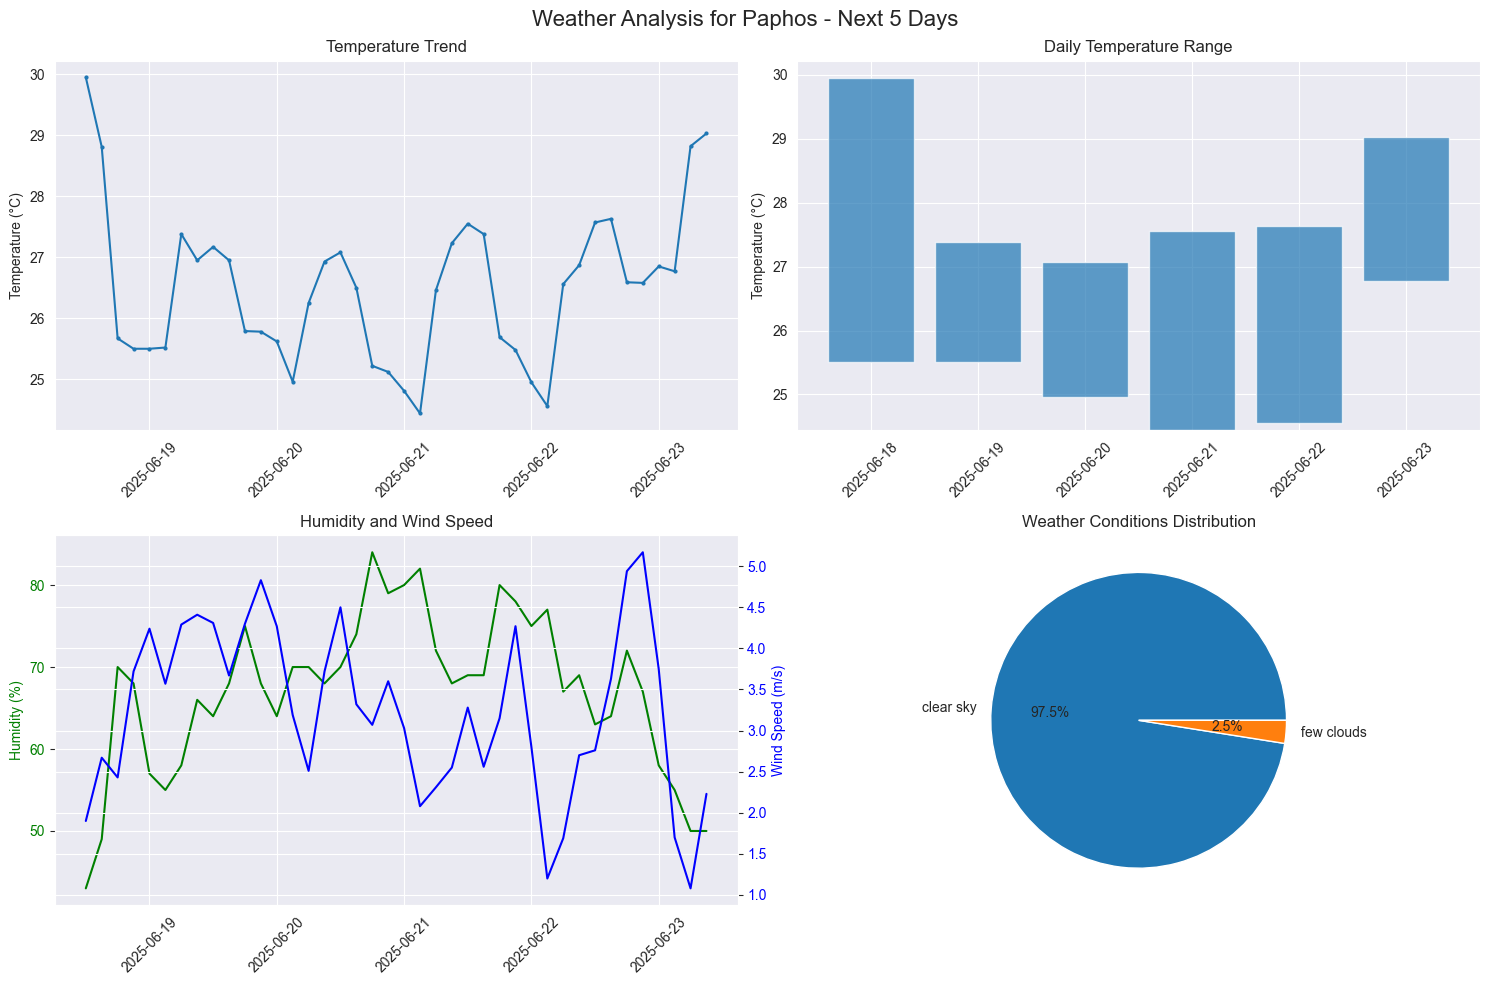

In [15]:
# Create visualizations
if 'weather_df' in locals() and weather_df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10)
    fig.suptitle(f'Weather Analysis for {CITY} - Next 5 Days', fontsize=16)

    # Temperature trend
    axes[0, 0].plot(weather_df['datetime'], weather_df['temperature'], marker='o', markersize=2)
    axes[0, 0].set_title('Temperature Trend')
    axes[0, 0].set_ylabel('Temperature (°C)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Daily temperature range
    daily_temp = weather_df.groupby('date')['temperature'].agg(['min', 'max'])
    x_pos = range(len(daily_temp))
    axes[0, 1].bar(x_pos, daily_temp['max'] - daily_temp['min'],
                   bottom=daily_temp['min'], alpha=0.7)
    axes[0, 1].set_title('Daily Temperature Range')
    axes[0, 1].set_ylabel('Temperature (°C)')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels([str(date) for date in daily_temp.index], rotation=45)

    # Humidity and Wind Speed
    axes[1, 0].plot(weather_df['datetime'], weather_df['humidity'], 'g-', label='Humidity (%)')
    axes[1, 0].set_ylabel('Humidity (%)', color='g')
    axes[1, 0].tick_params(axis='y', labelcolor='g')
    ax2 = axes[1, 0].twinx()
    ax2.plot(weather_df['datetime'], weather_df['wind_speed'], 'b-', label='Wind Speed (m/s)')
    ax2.set_ylabel('Wind Speed (m/s)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    axes[1, 0].set_title('Humidity and Wind Speed')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Weather conditions distribution
    condition_counts = weather_df['description'].value_counts()
    axes[1, 1].pie(condition_counts.values, labels=condition_counts.index, autopct='%1.1f%%')
    axes[1, 1].set_title('Weather Conditions Distribution')

    plt.tight_layout()
    plt.show()

In [16]:
# Additional analysis and summary
if 'weather_df' in locals() and weather_df is not None:
    print(f"\nWeather Analysis Summary for {CITY}:")
    print(f"• Average temperature: {weather_df['temperature'].mean():.1f}°C")
    print(f"• Temperature range: {weather_df['temperature'].min():.1f}°C to {weather_df['temperature'].max():.1f}°C")
    print(f"• Average humidity: {weather_df['humidity'].mean():.1f}%")
    print(f"• Average wind speed: {weather_df['wind_speed'].mean():.1f} m/s")
    print(f"• Most common weather: {weather_df['description'].mode().iloc[0]}")

    # Best and worst weather days
    daily_avg_temp = weather_df.groupby('date')['temperature'].mean()
    best_day = daily_avg_temp.idxmax()
    worst_day = daily_avg_temp.idxmin()

    print(f"\n• Warmest day expected: {best_day} ({daily_avg_temp[best_day]:.1f}°C)")
    print(f"• Coolest day expected: {worst_day} ({daily_avg_temp[worst_day]:.1f}°C)")



Weather Analysis Summary for Paphos:
• Average temperature: 26.5°C
• Temperature range: 24.4°C to 29.9°C
• Average humidity: 67.1%
• Average wind speed: 3.2 m/s
• Most common weather: clear sky

• Warmest day expected: 2025-06-23 (27.9°C)
• Coolest day expected: 2025-06-20 (26.0°C)
